In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving PCA3.csv to PCA3.csv


In [ ]:
finalDf = pd.read_csv(io.StringIO(uploaded['PCA3.csv'].decode('utf-8')), sep=',')

In [ ]:
finalDf.columns = ['Componente Principal 1', 'Componente Principal 2', 'Componente Principal 3', 'Type']
finalDf.head()

,Componente Principal 1,Componente Principal 2,Componente Principal 3,Type
0,-1.888339,0.493757,0.089824,1
1,-1.770391,0.799496,-0.181840,1
2,-2.067688,1.058030,-0.132354,1
3,-2.168182,1.112277,-0.388702,1
4,-1.898913,0.552587,0.317898,1


In [ ]:
finalDf["Type"].value_counts(True)

0    0.629808
1    0.370192
Name: Type, dtype: float64



---



# STRATIFY

Uso los datos estratificados para luego diferenciar los resultados en la red

In [ ]:
from sklearn.model_selection import train_test_split

x1 = finalDf.drop(['Type'], axis=1)
y = finalDf['Type']

datasets = train_test_split(x1, y, test_size=0.3, random_state=42, stratify=y)
x_train, x_test, y_train, y_test = datasets

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((145, 3), (63, 3), (145,), (63,))

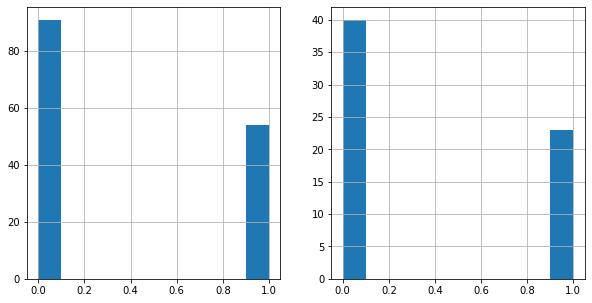

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

y_train.hist()

plt.subplot(1,2,2)

y_test.hist()

Red

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=200, random_state=42)

mlp.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
print("Train Accuracy: ", mlp.score(x_train,y_train))
print("Test Accuracy: ", mlp.score(x_test,y_test))

Train Accuracy:  0.7379310344827587
Test Accuracy:  0.6349206349206349


In [ ]:
print("Number of Iterations: ", mlp.n_iter_)
print("Output Layer Activation Function :", mlp.out_activation_)

Number of Iterations:  200
Output Layer Activation Function : logistic




---



In [ ]:
#Parte del entrenamiento
predicciones = mlp.predict(x_test)
clases_reales = y_test
predicciones_prob = mlp.predict_proba(x_test)

In [ ]:
def tupla_clase_prediccion(y_real, y_pred):
  return list(zip(y_real, y_pred))
#tupla_clase_prediccion(clases_reales, predicciones)[:10]

**Detallamos:**

- **Verdaderos positivos:** Tiene graso y la compu nos dice

- **Falsos positivos:** Digo que es graso pero me equivoque, en realidad no tiene (falsa alarma)

- **Verdaderos negativos:** No tiene graso y la compu nos dice lo mismo

- **Falsos negativos:** Los hígados grasos que se clasifican como normales

In [ ]:
def VP(clases_reales, predicciones):
    par_clase_prediccion = tupla_clase_prediccion(clases_reales, predicciones)
    return len([obs for obs in par_clase_prediccion if obs[0]==1 and obs[1]==1])

def VN(clases_reales, predicciones):
    par_clase_prediccion = tupla_clase_prediccion(clases_reales, predicciones)
    return len([obs for obs in par_clase_prediccion if obs[0]==0 and obs[1]==0])
    
def FP(clases_reales, predicciones):
    par_clase_prediccion = tupla_clase_prediccion(clases_reales, predicciones)
    return len([obs for obs in par_clase_prediccion if obs[0]==0 and obs[1]==1])

def FN(clases_reales, predicciones):
    par_clase_prediccion = tupla_clase_prediccion(clases_reales, predicciones)
    return len([obs for obs in par_clase_prediccion if obs[0]==1 and obs[1]==0])

print("""
Verdaderos Positivos: {}
Verdaderos Negativos: {}
Falsos Positivos: {}
Falsos Negativos: {}
""".format(VP(clases_reales, predicciones), VN(clases_reales, predicciones), FP(clases_reales, predicciones), FN(clases_reales, predicciones)    
))


Verdaderos Positivos: 4
Verdaderos Negativos: 36
Falsos Positivos: 4
Falsos Negativos: 19





---



Utilizamos Hiperparámetros para mejorar la red

In [ ]:
mlp_gs = MLPClassifier(max_iter=200, random_state=42)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (2,8,2), (2,50,3), (10,), (20,)],
    'activation': ['tanh', 'relu', 'sigmoid'],
    #'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
#Parte del entrenamiento
clf.fit(x_train, y_train)
predicciones = clf.predict(x_test)
clases_reales = y_test
predicciones_prob = clf.predict_proba(x_test)

In [ ]:
from sklearn.metrics import accuracy_score

predictions_train = clf.predict(x_train)
print("accurancy train:", accuracy_score(predictions_train, y_train))
predictions_test = clf.predict(x_test)
print("accurancy test:", accuracy_score(predictions_test, y_test))

accurancy train: 0.6689655172413793
accurancy test: 0.6507936507936508


In [ ]:
# Mejores parametros
print('Best parameters found:\n', clf.best_params_)

# Resultados
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (2, 50, 3), 'learning_rate': 'constant'}
0.655 (+/-0.185) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant'}
0.655 (+/-0.185) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive'}
0.655 (+/-0.115) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant'}
0.655 (+/-0.115) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive'}
0.648 (+/-0.134) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
0.648 (+/-0.134) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive'}
0.628 (+/-0.119) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (2, 8, 2), 'learning_rate': 'constant'}
0.62

In [ ]:
from sklearn.neural_network import MLPClassifier

mlpb = MLPClassifier(#solver='adam', 
                    activation='relu',
                    alpha=0.05,
                    hidden_layer_sizes=(100,), 
                    learning_rate='constant',
                    max_iter=200)

mlpb.fit(x_train, y_train) 
mlpb.score(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7448275862068966

In [ ]:
from sklearn.metrics import accuracy_score

predictions_train = mlpb.predict(x_train)
print("accurancy train:", accuracy_score(predictions_train, y_train))
predictions_test = mlpb.predict(x_test)
print("accurancy test:", accuracy_score(predictions_test, y_test))

accurancy train: 0.7448275862068966
accurancy test: 0.6507936507936508


In [ ]:
print("Number of Iterations: ", mlp.n_iter_)
print("Output Layer Activation Function :", mlp.out_activation_)

Number of Iterations:  200
Output Layer Activation Function : logistic


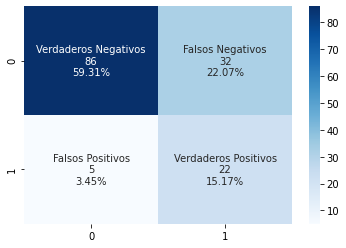

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

cf_matrix = confusion_matrix(predictions_train, y_train)
#plot_confusion_matrix(mlpb, x_train, y_train)
group_names = ['Verdaderos Negativos','Falsos Negativos','Falsos Positivos','Verdaderos Positivos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.savefig('PCA3prediccion_train(0.3).svg', format='svg', dpi=30)

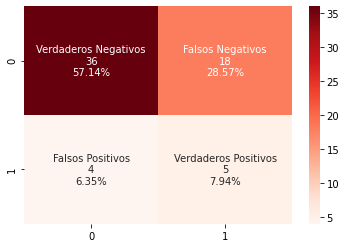

In [ ]:
cf_matrix2 = confusion_matrix(predictions_test, y_test)
#plot_confusion_matrix(mlpb, x_test, y_test)  
group_names = ['Verdaderos Negativos','Falsos Negativos', 'Falsos Positivos','Verdaderos Positivos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix2.flatten()/np.sum(cf_matrix2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(cf_matrix2, annot=labels, fmt='', cmap='Reds')
plt.savefig('PCA3prediccion_test(0.3).svg', format='svg', dpi=30)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(predictions_train, y_train))

              precision    recall  f1-score   support

           0       0.95      0.73      0.82       118
           1       0.41      0.81      0.54        27

    accuracy                           0.74       145
   macro avg       0.68      0.77      0.68       145
weighted avg       0.84      0.74      0.77       145



In [ ]:
print(classification_report(predictions_test, y_test))

              precision    recall  f1-score   support

           0       0.90      0.67      0.77        54
           1       0.22      0.56      0.31         9

    accuracy                           0.65        63
   macro avg       0.56      0.61      0.54        63
weighted avg       0.80      0.65      0.70        63



In [ ]:
y_true, y_pred = y_test, mlpb.predict(x_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

           0       0.67      0.90      0.77        40
           1       0.56      0.22      0.31        23

    accuracy                           0.65        63
   macro avg       0.61      0.56      0.54        63
weighted avg       0.63      0.65      0.60        63





---



In [ ]:
#Parte del entrenamiento
predicciones = mlpb.predict(x_test)
clases_reales = y_test
predicciones_prob = mlpb.predict_proba(x_test)

In [ ]:
def tupla_clase_prediccion(y_real, y_pred):
  return list(zip(y_real, y_pred))

In [ ]:
def VP(clases_reales, predicciones):
    par_clase_prediccion = tupla_clase_prediccion(clases_reales, predicciones)
    return len([obs for obs in par_clase_prediccion if obs[0]==1 and obs[1]==1])

def VN(clases_reales, predicciones):
    par_clase_prediccion = tupla_clase_prediccion(clases_reales, predicciones)
    return len([obs for obs in par_clase_prediccion if obs[0]==0 and obs[1]==0])
    
def FP(clases_reales, predicciones):
    par_clase_prediccion = tupla_clase_prediccion(clases_reales, predicciones)
    return len([obs for obs in par_clase_prediccion if obs[0]==0 and obs[1]==1])

def FN(clases_reales, predicciones):
    par_clase_prediccion = tupla_clase_prediccion(clases_reales, predicciones)
    return len([obs for obs in par_clase_prediccion if obs[0]==1 and obs[1]==0])

print("""
Verdaderos Positivos: {}
Verdaderos Negativos: {}
Falsos Positivos: {}
Falsos Negativos: {}
""".format(VP(clases_reales, predicciones), VN(clases_reales, predicciones), FP(clases_reales, predicciones), FN(clases_reales, predicciones)    
))


Verdaderos Positivos: 5
Verdaderos Negativos: 36
Falsos Positivos: 4
Falsos Negativos: 18



 # **Tasas de clasificación**

**1. Exactitud (Accuracy)**

La exactitud es una medida general de como se comporta el modelo, mide simplemente el porcentaje de casos que se han clasificado correctamente.

$$Exactitud=\frac{Numero~de~observaciones~correctamente~clasificadas}{Numero~de~observaciones~totales}= \frac{VP+VN}{VP+VN+FP+FN}$$

La exactitud es cuantos valores tuve bien entre el total

In [ ]:
from sklearn import metrics
metrics.accuracy_score(clases_reales, predicciones)

0.6507936507936508

**2. Precisión (Precission)**

La precisión indica la habilidad del modelo para clasificar como positivos los casos que son positivos.

$$Precisión=\frac{Numero~de~observaciones~positivas~correctamente~clasificadas}{Numero~de~observaciones~clasificadas~como~positivas}= \frac{VP}{VP+FP}$$

Habilidad del modelo para predecir como positivo lo que si es positivo

In [ ]:
metrics.average_precision_score(clases_reales, predicciones)

0.40648723257418906

**3. Exhaustividad o sensibilidad (Recall o True Positive Rate)**

La sensibilidad nos da una medida de la habilidad del modelo para encontrar todos los casos positivos. La sensibilidad se mide en función de una clase.

$$Sensibilidad=\frac{Numero~de~observaciones~positivas~clasificadas~como~positivas}{Numero~de~observaciones~positivas~totales}= \frac{VP}{VP+FN}$$

In [ ]:
metrics.recall_score(clases_reales, predicciones)

0.21739130434782608

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(clases_reales, predicciones)

array([[36,  4],
       [18,  5]])



---





---



# RED No-Stratify





In [ ]:
from sklearn.model_selection import train_test_split

x2 = finalDf.drop(['Type'], axis=1)
y = finalDf['Type']

datasets2 = train_test_split(x2, y, test_size=0.3, random_state=42)
x_train2, x_test2, y_train2, y_test2 = datasets2

x_train2.shape, x_train2.shape
x_train2.head()

,Componente Principal 1,Componente Principal 2,Componente Principal 3
146,-0.776312,0.636666,-0.495208
108,-2.337838,0.946294,-0.961587
177,6.960078,0.318733,-1.521217
31,-0.610580,0.200299,2.737630
12,-1.105450,0.671788,1.539373


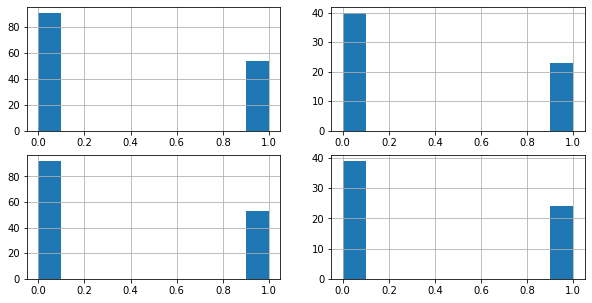

In [ ]:
fig = plt.figure(figsize=(10,5))

plt.subplot(2,2,1)
y_train.hist()

plt.subplot(2,2,2)
y_test.hist()

plt.subplot(2,2,3)
y_train2.hist()

plt.subplot(2,2,4)
y_test2.hist()

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp2 = MLPClassifier(max_iter=200)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (2,8,2), (2,50,3), (10,), (20,)],
    'activation': ['tanh', 'relu', 'sigmoid'],
    #'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [ ]:
from sklearn.model_selection import GridSearchCV

clf2 = GridSearchCV(mlp2, parameter_space, n_jobs=-1, cv=5)
clf2.fit(x_train2, y_train2)
clf2.score(x_train2, y_train2)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.6827586206896552

In [ ]:
from sklearn.metrics import accuracy_score

predictions_train2 = clf2.predict(x_train2)
print("accurancy train 3d no-stratify:", accuracy_score(predictions_train2, y_train2))
predictions_test2 = clf2.predict(x_test2)
print("accurancy test 3d no-stratify:", accuracy_score(predictions_test2, y_test2))

accurancy train 3d no-stratify: 0.6827586206896552
accurancy test 3d no-stratify: 0.6031746031746031


In [ ]:
# Mejores parametros
print('Best parameters found:\n', clf2.best_params_)

# Resultados
means2 = clf2.cv_results_['mean_test_score']
stds2 = clf2.cv_results_['std_test_score']
for mean2, std2, params in zip(means2, stds2, clf2.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean2, std2 * 2, params))

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant'}
0.628 (+/-0.101) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant'}
0.628 (+/-0.134) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive'}
0.614 (+/-0.171) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant'}
0.634 (+/-0.112) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive'}
0.628 (+/-0.211) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
0.641 (+/-0.178) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive'}
0.634 (+/-0.034) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (2, 8, 2), 'learning_rate': 'constant'}
0.662 (+/-0

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp2b = MLPClassifier(#solver='sgd', 
                    activation='tanh',
                    alpha=0.05,
                    hidden_layer_sizes=(10,), 
                    learning_rate='constant',
                    max_iter=200)

mlp2b.fit(x_train2, y_train2) 
mlp2b.score(x_train2, y_train2)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.6620689655172414



---





---



In [ ]:
from sklearn.metrics import accuracy_score

predictions_train2 = mlp2b.predict(x_train2)
print("accurancy train:", accuracy_score(predictions_train2, y_train2))
predictions_test2 = mlp2b.predict(x_test2)
print("accurancy test:", accuracy_score(predictions_test2, y_test2))

accurancy train: 0.6620689655172414
accurancy test: 0.6666666666666666


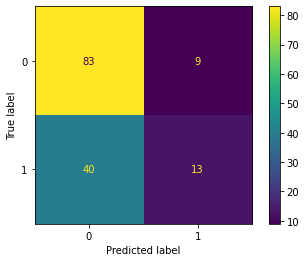

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

confusion_matrix(predictions_train2, y_train2)
plot_confusion_matrix(mlp2b, x_train2, y_train2) 

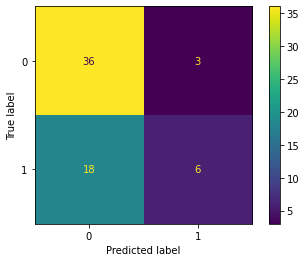

In [ ]:
confusion_matrix(predictions_test2, y_test2)
plot_confusion_matrix(mlp2b, x_test2, y_test2)  

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(predictions_test2, y_test2))

              precision    recall  f1-score   support

           0       0.92      0.67      0.77        54
           1       0.25      0.67      0.36         9

    accuracy                           0.67        63
   macro avg       0.59      0.67      0.57        63
weighted avg       0.83      0.67      0.72        63



In [ ]:
y_true2, y_pred2 = y_test2 , mlp2b.predict(x_test2)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true2, y_pred2))

Results on the test set:
              precision    recall  f1-score   support

           0       0.67      0.92      0.77        39
           1       0.67      0.25      0.36        24

    accuracy                           0.67        63
   macro avg       0.67      0.59      0.57        63
weighted avg       0.67      0.67      0.62        63



In [ ]:
#Parte del entrenamiento
predicciones2 = mlp2b.predict(x_test2)
clases_reales2 = y_test2
predicciones_prob2 = mlp2b.predict_proba(x_test2)

In [ ]:
def tupla_clase_prediccion(y_real2, y_pred2):
  return list(zip(y_real2, y_pred2))
#tupla_clase_prediccion(clases_reales2, predicciones2)[:10]

In [ ]:
def VP(clases_reales2, predicciones2):
    par_clase_prediccion2 = tupla_clase_prediccion(clases_reales2, predicciones2)
    return len([obs for obs in par_clase_prediccion2 if obs[0]==1 and obs[1]==1])

def VN(clases_reales2, predicciones2):
    par_clase_prediccion2 = tupla_clase_prediccion(clases_reales2, predicciones2)
    return len([obs for obs in par_clase_prediccion2 if obs[0]==0 and obs[1]==0])
    
def FP(clases_reales2, predicciones2):
    par_clase_prediccion2 = tupla_clase_prediccion(clases_reales2, predicciones2)
    return len([obs for obs in par_clase_prediccion2 if obs[0]==0 and obs[1]==1])

def FN(clases_reales2, predicciones2):
    par_clase_prediccion2 = tupla_clase_prediccion(clases_reales2, predicciones2)
    return len([obs for obs in par_clase_prediccion2 if obs[0]==1 and obs[1]==0])


print("""
Verdaderos Positivos: {}
Verdaderos Negativos: {}
Falsos Positivos: {}
Falsos Negativos: {}
""".format(VP(clases_reales2, predicciones2), VN(clases_reales2, predicciones2), FP(clases_reales2, predicciones2), FN(clases_reales2, predicciones2)    
))


Verdaderos Positivos: 6
Verdaderos Negativos: 36
Falsos Positivos: 3
Falsos Negativos: 18



In [ ]:
metrics.accuracy_score(clases_reales2, predicciones2)

0.6666666666666666

In [ ]:
metrics.average_precision_score(clases_reales, predicciones)

0.40648723257418906

In [ ]:
metrics.recall_score(clases_reales, predicciones)

0.21739130434782608